In [1]:
import numpy as np
import matplotlib.pyplot as plt

import utils
import model_spectra as NN
import fitting

np.set_printoptions(formatter={'float': lambda x: "{0:0.1f}".format(x)})

# Generate spectral mask from Kirby et al. 2008

In [2]:
def generate_mask_from_list(**kwargs):
    wavelength = utils.load_wavelength_array()
    mask = np.array([])
    for key in kwargs:
        lower,upper = kwargs[key]
        temp_mask = np.where((wavelength > lower) & (wavelength < upper))
        mask = np.append(mask,temp_mask)
    return(mask.astype(int))

In [3]:
kirby_2008 = {'B band':[6864,7020],
             'A band':[7591,7703],
             'strong telluric asorption':[8225,8265],
             'Ca I 6343':[6341,6346],
             'Ca I 6362':[6356,6365],
             'H alpha':[6559.797,6565.797],
             'K I 7665':[7662,7668],
             'V I 8116,8119 hyperfine structure':[8113,8123],
             'poorly modeled absorption in Arcturus':[8317,8330],
             'Ca II 8498':[8488.023,8508.023],
             'Ca II 8542':[8525.091,8561.091],
             'Ca II 8662':[8645.141,8679.141],
             'Mg I 8807':[8804.756,8809.756],
            }

# Check label recovery 

Best Fit Labels:
[0.0 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5 4102.4 0.5 9.9]
True Labels:
[-0.0 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5 -1.5 4100.0 0.5 10.0]


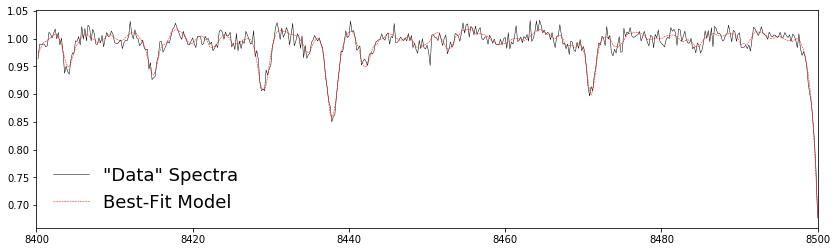

In [10]:
# read in the standard wavelength grid onto which we interpolate spectra.
wavelength = utils.load_wavelength_array()

# read in all individual neural networks we'll need. 
NN_coeffs = utils.read_in_neural_network(name='norm_spectra_approx')

# Generate a spectrum from labels and NN
feh = -1.5
alphafe = -0.0
alpha = alphafe + feh
Teff = 4100
logg = 0.5
dv = 10
real_labels = np.array([alphafe, alpha, alpha, alpha, alpha, alpha, alpha, feh, Teff, logg, dv])
real_spec = NN.get_spectrum_from_neural_net(labels=real_labels, NN_coeffs=NN_coeffs)
data_spec = real_spec + 0.01 * np.random.randn(len(real_spec))
spec_err = 0.01 * np.ones(len(wavelength))

# Apply Mask
mask = generate_mask_from_list(**kirby_2008)
spec_err[mask] = 999.

# Fit spectrum
popt, pcov, model_spec = fitting.fit_normalized_spectrum_single_star_model(norm_spec = data_spec,
                                                                           spec_err = spec_err,
                                                                           NN_coeffs = NN_coeffs,
                                                                           p0 = None, num_p0 = 1)

# zoom in on a small region of the spectrum so we can see what's going on.
lambda_min, lambda_max = 8400, 8500# for plotting 
plt.figure(figsize=(14, 4))
m = (wavelength < lambda_max) & (wavelength > lambda_min)
plt.plot(wavelength[m], data_spec[m], 'k', lw=0.5, label = '"Data" Spectra')
plt.plot(wavelength[m], model_spec[m], 'r--', lw=0.5, label = 'Best-Fit Model')
plt.xlim(lambda_min, lambda_max)
plt.legend(loc = 'best', frameon = False, fontsize = 18)

print('Best Fit Labels:')
print(popt)

print('True Labels:')
print(real_labels)

# Read in and fit training spectra

In [6]:
D_PayneDir = '/Users/Nathan/Documents/Berkeley/Chemical_Evolution/DEIMOS/D-Payne/'
SpectraDir = D_PayneDir + 'spectra/synth_spectra/'
SpectraFile = 'convolved_synthetic_spectra_MIST.npz'
temp = np.load(SpectraDir + SpectraFile)
spectra = temp['spectra']
norm_spectra = temp['norm_spectra_approx']
labels = temp['labels']
temp.close()



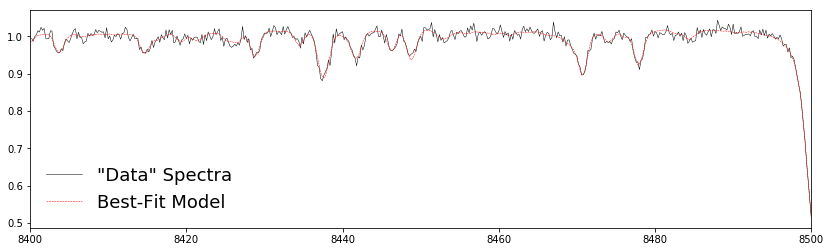

Best Fit Labels:
[0.4 0.1 0.2 0.1 0.1 0.2 0.2 -0.2 5349.6 2.5 0.3]
True Labels:
[0.4 0.2 0.2 0.2 0.2 0.2 0.2 -0.2 5358.5 2.4 0.0]


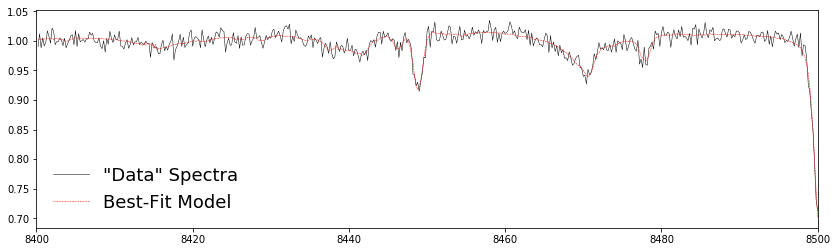

Best Fit Labels:
[0.4 -0.2 -0.2 -0.1 -0.1 -0.1 -0.1 -0.5 6847.4 3.4 0.4]
True Labels:
[0.4 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.5 6888.7 3.4 0.0]


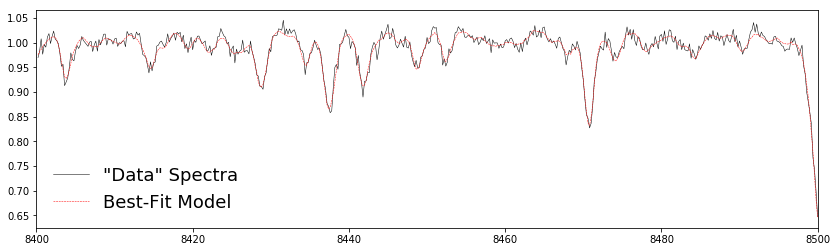

Best Fit Labels:
[-0.6 -0.6 -0.6 -0.6 -0.6 -0.6 -0.6 -0.0 4810.9 4.6 -0.2]
True Labels:
[-0.6 -0.6 -0.6 -0.6 -0.6 -0.6 -0.6 0.0 4840.2 4.6 0.0]


In [ ]:
n = np.random.randint(0,len(norm_spectra),10)

for i, spec in enumerate(norm_spectra[n]):
    j = n[i]
    real_labels = np.append(labels[j],0.0)
    real_spec = spec
    data_spec = real_spec + 0.01 * np.random.randn(len(real_spec))
    spec_err = 0.01 * np.ones(len(real_spec))
    
    # Apply Mask
    mask = generate_mask_from_list(**kirby_2008)
    spec_err[mask] = 999.
    
    # Restore NN
    NN_coeffs = utils.read_in_neural_network(name='norm_spectra_approx')
    
    # Apply Mask
    mask = generate_mask_from_list(**kirby_2008)
    spec_err[mask] = 999.

    # Fit spectrum
    popt, pcov, model_spec = fitting.fit_normalized_spectrum_single_star_model(norm_spec = data_spec,
                                                                               spec_err = spec_err,
                                                                               NN_coeffs = NN_coeffs,
                                                                               p0 = None, num_p0 = 1)

    # zoom in on a small region of the spectrum so we can see what's going on.
    lambda_min, lambda_max = 8400, 8500# for plotting 
    plt.figure(figsize=(14, 4))
    m = (wavelength < lambda_max) & (wavelength > lambda_min)
    plt.plot(wavelength[m], data_spec[m], 'k', lw=0.5, label = '"Data" Spectra')
    plt.plot(wavelength[m], model_spec[m], 'r--', lw=0.5, label = 'Best-Fit Model')
    plt.xlim(lambda_min, lambda_max)
    plt.legend(loc = 'best', frameon = False, fontsize = 18)
    plt.show()
    
    print('Best Fit Labels:')
    print(popt)
    
    print('True Labels:')
    print(real_labels)